## Aggregated analysis for intermedia agenda alignment at the topic level

In [25]:
import os 
import pandas as pd
import numpy as np

from src.utils.dict_loader import TopicDictionary
from src.utils.output_loader import load_all_sum_vectors, load_all_topvecs, load_all_bstr_arrs
from src.utils.downstream_aggregate import normalize

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]

START2016 = pd.to_datetime(configs["START2016"])
END2016 = pd.to_datetime(configs["END2016"])
START2020 = pd.to_datetime(configs["START2020"])
END2020 = pd.to_datetime(configs["END2020"])

INPUT_FPATH = configs["SUM_TOPVEC_PATH"]
print(f"INPUT_FPATH=={INPUT_FPATH}")

OUTPUT_FPATH = ROOTPATH + "output/figs/"
print(f"OUTPUT_FPATH=={OUTPUT_FPATH}")

INPUT_FPATH==/Users/yijingch/Documents/GITHUB/intermedia-agenda-setting/output/sum-topvec-min2-gtm1/
OUTPUT_FPATH==/Users/yijingch/Documents/GITHUB/intermedia-agenda-setting/output/figs/


In [26]:
from src.utils.dict_configuration import dictionary2016, dictionary2020

year = 2016
if year == 2016:
    cand1 = "trump"
    cand2 = "clinton"
    dictionary = dictionary2016
elif year == 2020:
    cand1 = "biden"
    cand2 = "trump"
    dictionary = dictionary2020

In [27]:
ABBR_MAP = {
    "healthcare":"HLTH", 
    "election_campaign":"ELEC", 
    "general_controversies":"GENC", 
    "trump_controversies":"TRUC", 
    "civil_rights":"CIVR", 
    "crime":"CRIM", 
    "clinton_controversies":"CLIC", 
    "biden_controversies":"BIDC",
    "intl_affairs":"INTL", 
    "government_ops":"GVOP", 
    "energy":"ENRG", 
    "economy":"ECON", 
    "sstc":"SSTC", 
    "foreign_trade":"FRTR", 
    "immigration":"IMMI", 
    "social_welfare":"SOWL", 
    "education":"EDUC", 
    "environment":"ENVR", 
    "labour":"LABR", 
    "defence":"DEFC", 
    "religion":"RELG", 
    "agriculture":"AGRI", 
    "housing":"HOUS", 
    "transportation":"TRSP", 
    "land_water_management":"LWMN", 
    "forestry":"FRST", 
    "culture":"CLTR", 
    "no_topic":"NA", 
}

MARKER_MAP = {
    "healthcare":".",
    "election_campaign":"^",
    "general_controversies":"*",
    "trump_controversies":"*",
    "civil_rights":".",
    "crime":".",
    "clinton_controversies":"*",
    "biden_controversies":"*",
    "intl_affairs":".",
    "government_ops":"^",
    "energy":".",
    "economy":".",
    "sstc":".",
    "foreign_trade":".",
    "immigration":".",
    "social_welfare":".",
    "education":".",
    "environment":".",
    "labour":".",
    "defence":".",
    "religion":".",
    "agriculture":".",
    "housing":".",
    "transportation":".",
    "land_water_management":".",
    "forestry":".",
    "culture":".",
    "no_topic":"", 
}

In [28]:
sum_topvecs2016 = load_all_sum_vectors(year=2016, sumvec_fpath=INPUT_FPATH, vector_type="topvecs")
sum_topvecs2020 = load_all_sum_vectors(year=2020, sumvec_fpath=INPUT_FPATH, vector_type="topvecs")

bstr_sum_topvecs2016 = load_all_sum_vectors(year=2016, sumvec_fpath=INPUT_FPATH, vector_type="topvecs", load_bstr=True)
bstr_sum_topvecs2020 = load_all_sum_vectors(year=2020, sumvec_fpath=INPUT_FPATH, vector_type="topvecs", load_bstr=True)

In [29]:
# validating using weekly aggregates

INPUT_FPATH2 = configs["WEEK_TOPVEC_PATH"]
print(f"INPUT_FPATH2=={INPUT_FPATH2}")

# topvec_dfs2016 = load_all_topvecs(year=2016, topvec_fpath=INPUT_FPATH2, normalize_by_unit=False, trim=[START2016, END2016])
# topvec_dfs2020 = load_all_topvecs(year=2020, topvec_fpath=INPUT_FPATH2, normalize_by_unit=False, trim=[START2020, END2020])

# bstr_arrs2016 = load_all_bstr_arrs(year=2016, vec_fpath=INPUT_FPATH2, vec_type="topvecs", normalize_by_unit=False)
# bstr_arrs2020 = load_all_bstr_arrs(year=2020, vec_fpath=INPUT_FPATH2, vec_type="topvecs", normalize_by_unit=False)



INPUT_FPATH2==/Users/yijingch/Documents/GITHUB/intermedia-agenda-setting/output/week-topvec-min2-gtm1/


In [30]:
def get_sum_vecs_from_df(vec_dfs):
    sum_vecs = {}
    new_big_mat = []
    for cand_dfs in vec_dfs["headline"]:
        new_cand_mat = []
        for media_df in cand_dfs:
            new_cand_mat.append(np.sum(np.array(media_df["majority_topvec"].tolist()), axis=0))
        new_big_mat.append(new_cand_mat)
    sum_vecs["headline"] = new_big_mat
    return sum_vecs

def get_sum_vecs_from_bstr_arr(bstr_arrs):
    bstr_sum_vecs = {}
    new_big_mat = []
    for cand_arrs in bstr_arrs["headline"]:
        new_cand_mat = []
        for media_arr in cand_arrs:
            new_cand_mat.append(np.sum(media_arr, axis=1))
        new_big_mat.append(new_cand_mat)
    bstr_sum_vecs["headline"] = new_big_mat
    return bstr_sum_vecs

In [31]:
TOPICS2DROP = [
    "election_campaign", "general_controversies", "no_topic", 
    "forestry", "land_water_management", "agriculture", "housing", 
    "transportation", "culture"]

TOPICS2DROP_IDX2016 = [dictionary2016.topic2index[x] for x in TOPICS2DROP]
TOPICS2DROP_IDX2020 = [dictionary2020.topic2index[x] for x in TOPICS2DROP]

In [32]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def normalize(arr, smooth=0):
    return (np.array(arr)+smooth)/np.sum(np.array(arr)+smooth)

def get_correlation(arr1, arr2, idx2drop=[], corr_func=pearsonr):
    if len(idx2drop) > 0:
        arr1_clean = np.delete(arr1, idx2drop)
        arr2_clean = np.delete(arr2, idx2drop)
    else:
        arr1_clean = arr1
        arr2_clean = arr2
    arr1_clean = normalize(arr1_clean)
    arr2_clean = normalize(arr2_clean)
    corr, p = corr_func(arr1_clean, arr2_clean)
    return corr, p

In [33]:
import warnings
warnings.filterwarnings("ignore")

def make_plot_df(year):
    plot_df = pd.DataFrame()
    if year == 2016:
        cand1 = "trump"
        cand2 = "clinton"
        dictionary = dictionary2016
        sum_topvecs = sum_topvecs2016
        bstr_arrs = bstr_sum_topvecs2016
    elif year == 2020:
        cand1 = "biden"
        cand2 = "trump"
        dictionary = dictionary2020
        sum_topvecs = sum_topvecs2020
        bstr_arrs = bstr_sum_topvecs2020
    plot_df["topic"] = dictionary.topics
    nruns = bstr_sum_topvecs2016["headline"][0][0].shape[0]
    for i,cand in enumerate([cand1, cand2]):
        plot_df[f"lowc_{cand}"] = normalize(sum_topvecs["headline"][i][1])
        plot_df[f"trad_{cand}"] = normalize(sum_topvecs["headline"][i][2])
        plot_df[f"left_{cand}"] = normalize(sum_topvecs["headline"][i][3])
        plot_df[f"right_{cand}"] = normalize(sum_topvecs["headline"][i][5])
        # plot_df[f"dem_{cand}"] = normalize(sum_topvecs["survey"][i][1])
        # plot_df[f"rep_{cand}"] = normalize(sum_topvecs["survey"][i][3])
        for r in range(nruns):
            plot_df[f"bstr{r}_lowc_{cand}"] = normalize(bstr_arrs["headline"][i][1][r])
            plot_df[f"bstr{r}_trad_{cand}"] = normalize(bstr_arrs["headline"][i][2][r])
            plot_df[f"bstr{r}_left_{cand}"] = normalize(bstr_arrs["headline"][i][3][r])
            plot_df[f"bstr{r}_right_{cand}"] = normalize(bstr_arrs["headline"][i][5][r])
            # plot_df[f"bstr{r}_dem_{cand}"] = normalize(bstr_arrs["survey"][i][1][r])
            # plot_df[f"bstr{r}_rep_{cand}"] = normalize(bstr_arrs["survey"][i][3][r])

    plot_df.sort_values(by="trad_trump", ascending=True, inplace=True)
    plot_df = plot_df[~plot_df["topic"].isin(TOPICS2DROP)]
    plot_df["marker"] = plot_df["topic"].map(lambda x: MARKER_MAP[x])
    return plot_df

plot_df2016 = make_plot_df(2016)
plot_df2020 = make_plot_df(2020)

In [34]:
COLORMAP = {
    "low-cred": "#E55807",
    "traditional": "#445069",
    "left": "#4A55A2",
    "right": "#B31312", 
    "DEM": "#4A55A2",
    "REP": "#B31312", 
}

In [35]:
print("2016")
print("low-cred vs traditional:")
print(get_correlation(plot_df2016["lowc_trump"],plot_df2016["trad_trump"]))
print(get_correlation(plot_df2016["lowc_clinton"],plot_df2016["trad_clinton"]))
print("left vs right:")
print(get_correlation(plot_df2016["left_trump"],plot_df2016["right_trump"]))
print(get_correlation(plot_df2016["left_clinton"],plot_df2016["right_clinton"]))

print("\n")
print("2020")
print("low-cred vs traditional:")
print(get_correlation(plot_df2020["lowc_trump"],plot_df2020["trad_trump"]))
print(get_correlation(plot_df2020["lowc_biden"],plot_df2020["trad_biden"]))
print("left vs right:")
print(get_correlation(plot_df2020["left_trump"],plot_df2020["right_trump"]))
print(get_correlation(plot_df2020["left_biden"],plot_df2020["right_biden"]))

2016
low-cred vs traditional:
(0.997382974265667, 1.0971465970732616e-19)
(0.8908183101637355, 7.171642528368921e-07)
left vs right:
(0.9917494776085355, 1.0520190869795349e-15)
(0.9022732988009227, 3.066808470429038e-07)


2020
low-cred vs traditional:
(0.946653357855517, 2.7881493314682913e-09)
(0.8446846356681926, 1.0333461995387031e-05)
left vs right:
(0.9555606884525569, 6.650880550866935e-10)
(0.8692951965683419, 2.819513598900288e-06)


In [36]:
(0.9466+0.9555)/2

0.95105

In [37]:
(0.8446846356681926+0.8692951965683419)/2

0.8569899161182672

In [38]:
print("2016")
print("low-cred vs traditional:")
print(get_correlation(plot_df2016["lowc_trump"],plot_df2016["trad_trump"], corr_func=pearsonr))
print(get_correlation(plot_df2016["lowc_clinton"],plot_df2016["trad_clinton"], corr_func=pearsonr))
print("left vs right:")
print(get_correlation(plot_df2016["left_trump"],plot_df2016["right_trump"], corr_func=pearsonr))
print(get_correlation(plot_df2016["left_clinton"],plot_df2016["right_clinton"], corr_func=pearsonr))

print("\n")
print("2020")
print("low-cred vs traditional:")
print(get_correlation(plot_df2020["lowc_trump"],plot_df2020["trad_trump"], corr_func=pearsonr))
print(get_correlation(plot_df2020["lowc_biden"],plot_df2020["trad_biden"], corr_func=pearsonr))
print("left vs right:")
print(get_correlation(plot_df2020["left_trump"],plot_df2020["right_trump"], corr_func=pearsonr))
print(get_correlation(plot_df2020["left_biden"],plot_df2020["right_biden"], corr_func=pearsonr))

2016
low-cred vs traditional:
(0.997382974265667, 1.0971465970732616e-19)
(0.8908183101637355, 7.171642528368921e-07)
left vs right:
(0.9917494776085355, 1.0520190869795349e-15)
(0.9022732988009227, 3.066808470429038e-07)


2020
low-cred vs traditional:
(0.946653357855517, 2.7881493314682913e-09)
(0.8446846356681926, 1.0333461995387031e-05)
left vs right:
(0.9555606884525569, 6.650880550866935e-10)
(0.8692951965683419, 2.819513598900288e-06)


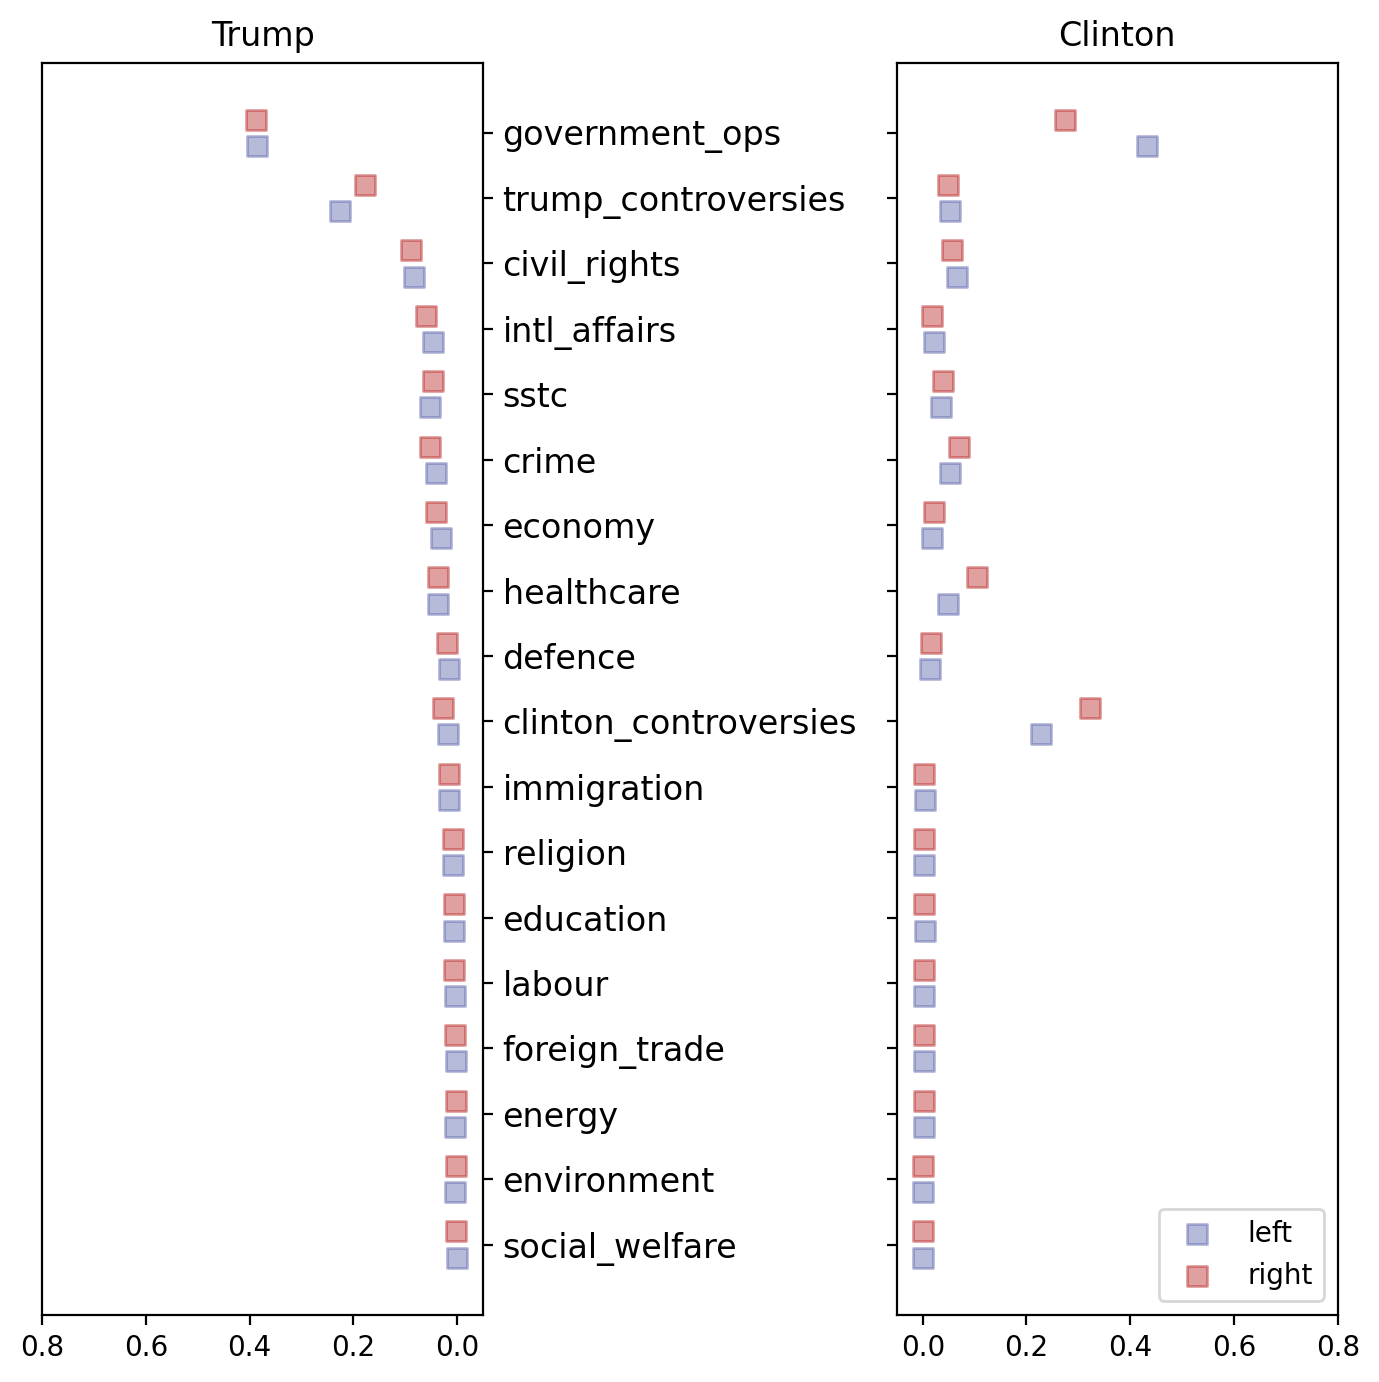

In [39]:
figs, axes = plt.subplots(ncols=2, figsize=(7,7), sharey=True)
diff = 0.2
# axes[0].scatter(plot_df2016["lowc_trump"], np.arange(len(plot_df2016))+diff, color=COLORMAP["low-cred"], alpha=0.4, s=50, marker="s", label="lowc")
# axes[1].scatter(plot_df2016["lowc_clinton"], np.arange(len(plot_df2016))+diff, color=COLORMAP["low-cred"], alpha=0.4, s=50, marker="s", label="lowc")
# axes[0].scatter(plot_df2016["trad_trump"], np.arange(len(plot_df2016))-diff, color=COLORMAP["traditional"], alpha=0.4, s=50, marker="s", label="trad")
# axes[1].scatter(plot_df2016["trad_clinton"], np.arange(len(plot_df2016))-diff, color=COLORMAP["traditional"], alpha=0.4, s=50, marker="s", label="trad")

axes[0].scatter(plot_df2016["left_trump"], np.arange(len(plot_df2016))-diff, color=COLORMAP["left"], alpha=.4, s=50, marker="s", label="left")
axes[1].scatter(plot_df2016["left_clinton"], np.arange(len(plot_df2016))-diff, color=COLORMAP["left"], alpha=.4, s=50, marker="s", label="left")
axes[0].scatter(plot_df2016["right_trump"], np.arange(len(plot_df2016))+diff, color=COLORMAP["right"], alpha=.4, s=50, marker="s", label="right")
axes[1].scatter(plot_df2016["right_clinton"], np.arange(len(plot_df2016))+diff, color=COLORMAP["right"], alpha=.4, s=50, marker="s", label="right")

# axes[0].scatter(plot_df2016["dem_trump"], np.arange(len(plot_df2016))-diff, color=COLORMAP["DEM"], s=50, marker="+", label="dem")
# axes[1].scatter(plot_df2016["dem_clinton"], np.arange(len(plot_df2016))-diff, color=COLORMAP["DEM"], s=50, marker="+", label="dem")
# axes[0].scatter(plot_df2016["rep_trump"], np.arange(len(plot_df2016))+diff, color=COLORMAP["REP"], s=50, marker="+", label="rep")
# axes[1].scatter(plot_df2016["rep_clinton"], np.arange(len(plot_df2016))+diff, color=COLORMAP["REP"], s=50, marker="+", label="rep")

axes[0].yaxis.tick_right()
for i in [0,1]:
    axes[i].set_xlim(-.05,0.8)
axes[0].set_title("Trump") 
axes[1].set_title("Clinton")
axes[0].set_yticks(range(len(plot_df2016)), plot_df2016["topic"], fontsize=12)
axes[1].legend(loc=4)
axes[0].invert_xaxis()
plt.tight_layout()
# plt.savefig(OUTPUT_FPATH + "topic-breakdown-credibility-partisan-2016.png", dpi=300)
# plt.savefig(OUTPUT_FPATH + "topic-breakdown-ideology-partisan-2016.png", dpi=300)

In [40]:
# figs, axes = plt.subplots(ncols=2, figsize=(7,7), sharey=True)
# diff = 0.2
# # axes[0].scatter(plot_df2020["lowc_trump"], np.arange(len(plot_df2020))+diff, color=COLORMAP["low-cred"], alpha=0.4, s=50, marker="s", label="lowc")
# # axes[1].scatter(plot_df2020["lowc_biden"], np.arange(len(plot_df2020))+diff, color=COLORMAP["low-cred"], alpha=0.4, s=50, marker="s", label="lowc")
# # axes[0].scatter(plot_df2020["trad_trump"], np.arange(len(plot_df2020))-diff, color=COLORMAP["traditional"], alpha=0.4, s=50, marker="s", label="trad")
# # axes[1].scatter(plot_df2020["trad_biden"], np.arange(len(plot_df2020))-diff, color=COLORMAP["traditional"], alpha=0.4, s=50, marker="s", label="trad")

# axes[0].scatter(plot_df2020["left_trump"], np.arange(len(plot_df2020))-diff, color=COLORMAP["left"], alpha=.4, s=50, marker="s", label="left")
# axes[1].scatter(plot_df2020["left_biden"], np.arange(len(plot_df2020))-diff, color=COLORMAP["left"], alpha=.4, s=50, marker="s", label="left")
# axes[0].scatter(plot_df2020["right_trump"], np.arange(len(plot_df2020))+diff, color=COLORMAP["right"], alpha=.4, s=50, marker="s", label="right")
# axes[1].scatter(plot_df2020["right_biden"], np.arange(len(plot_df2020))+diff, color=COLORMAP["right"], alpha=.4, s=50, marker="s", label="right")

# axes[0].scatter(plot_df2020["dem_trump"], np.arange(len(plot_df2020))-diff, color=COLORMAP["DEM"], s=50, marker="+", label="dem")
# axes[1].scatter(plot_df2020["dem_biden"], np.arange(len(plot_df2020))-diff, color=COLORMAP["DEM"], s=50, marker="+", label="dem")
# axes[0].scatter(plot_df2020["rep_trump"], np.arange(len(plot_df2020))+diff, color=COLORMAP["REP"], s=50, marker="+", label="rep")
# axes[1].scatter(plot_df2020["rep_biden"], np.arange(len(plot_df2020))+diff, color=COLORMAP["REP"], s=50, marker="+", label="rep")

# axes[0].yaxis.tick_right()
# for i in [0,1]:
#     axes[i].set_xlim(-.05,0.8)
# axes[0].set_title("Trump") 
# axes[1].set_title("biden")
# axes[0].set_yticks(range(len(plot_df2020)), plot_df2020["topic"], fontsize=12)
# axes[1].legend(loc=4)
# axes[0].invert_xaxis()
# plt.tight_layout()
# # plt.savefig(OUTPUT_FPATH + "topic-breakdown-credibility-partisan-2020.png", dpi=300)
# # plt.savefig(OUTPUT_FPATH + "topic-breakdown-ideology-partisan-2020.png", dpi=300)

## Scatterplots

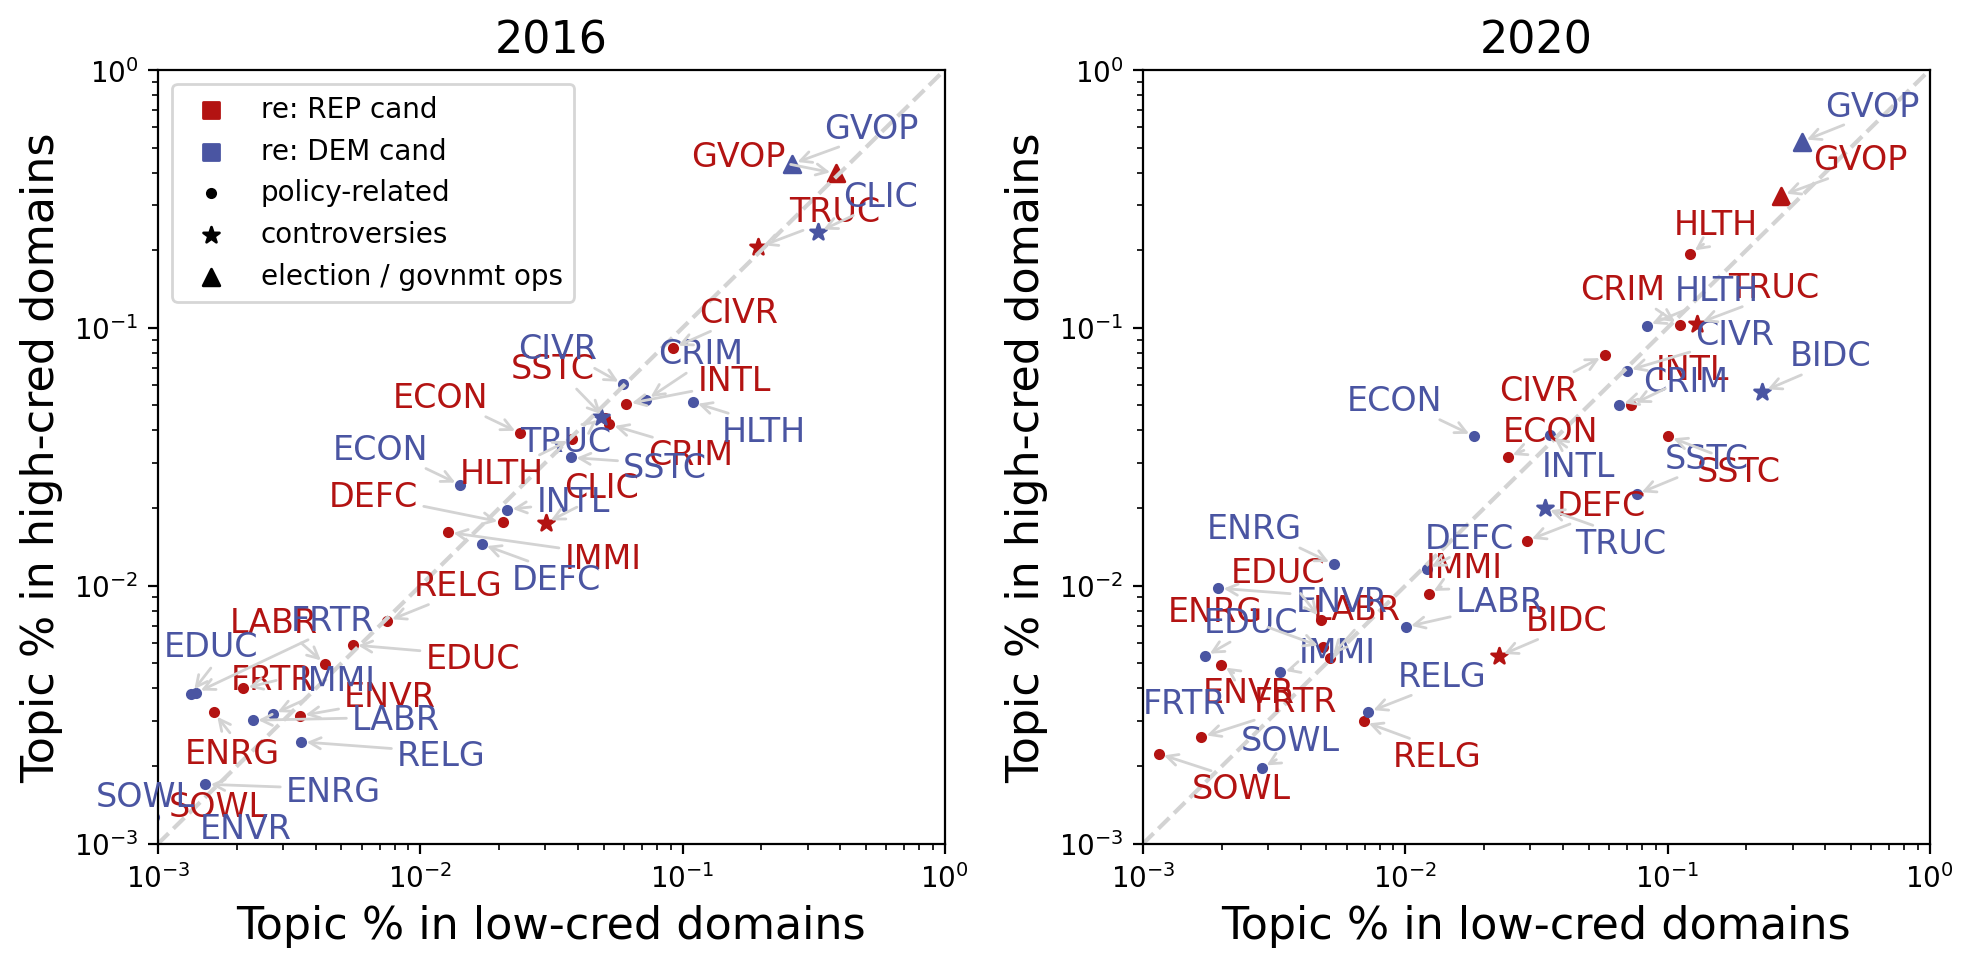

In [59]:
from adjustText import adjust_text
figs, ax = plt.subplots(ncols=2, figsize=(10,5))
# figs, ax = plt.subplots(nrows=2, figsize=(5,9), sharey=True, sharex=True)

# for legend
ax[0].scatter([-10],[-10], color=COLORMAP["right"], marker="s", label="re: REP cand")
ax[0].scatter([-10],[-10], color=COLORMAP["left"], marker="s", label="re: DEM cand")

for marker_group, topic_type in zip([".", "*", "^"], ["policy-related", "controversies", "election / govnmt ops"]):
    plot_df_subset2016 = plot_df2016[plot_df2016["marker"]==marker_group]
    plot_df_subset2020 = plot_df2020[plot_df2020["marker"]==marker_group]

    ax[0].scatter([-10],[-10], color="black", marker=marker_group, label=topic_type)
    # ax[1].scatter([-10],[-10], color="black", marker=marker_group, label=topic_type)

    ax[0].scatter(plot_df_subset2016["lowc_trump"], plot_df_subset2016["trad_trump"], color=COLORMAP["right"], marker=marker_group)
    ax[0].scatter(plot_df_subset2016["lowc_clinton"], plot_df_subset2016["trad_clinton"], color=COLORMAP["left"], marker=marker_group)

    ax[1].scatter(plot_df_subset2020["lowc_trump"], plot_df_subset2020["trad_trump"], color=COLORMAP["right"], marker=marker_group)
    ax[1].scatter(plot_df_subset2020["lowc_biden"], plot_df_subset2020["trad_biden"], color=COLORMAP["left"], marker=marker_group)

# # uniform marker
# ax[0].scatter(plot_df2016["lowc_trump"], plot_df2016["trad_trump"], color=COLORMAP["right"], label="Trump")
# ax[0].scatter(plot_df2016["lowc_clinton"], plot_df2016["trad_clinton"], color=COLORMAP["left"], label="Clinton")

# ax[1].scatter(plot_df2020["lowc_trump"], plot_df2020["trad_trump"], color=COLORMAP["right"], label="Trump")
# ax[1].scatter(plot_df2020["lowc_biden"], plot_df2020["trad_biden"], color=COLORMAP["left"], label="Biden")


for i,year in enumerate([2016, 2020]):
    ax[i].plot([-1,1],[-1,1], color="lightgrey", linestyle="--")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].set_title(year, fontsize=16)
    ax[i].set_xlabel("Topic % in low-cred domains", fontsize=16)
    ax[i].set_ylabel("Topic % in high-cred domains", fontsize=16)
    ax[i].set_xlim(1e-3, 1)
    ax[i].set_ylim(1e-3, 1)
    if i == 0:
        # ax[i].set_ylabel("Topic % in high-cred domains", fontsize=16)
        # ax[i].set_xlabel("Topic % in low-cred domains", fontsize=16)
        ax[i].legend(loc=2, fontsize=10)

x1_2016 = plot_df2016["lowc_trump"].tolist()
y1_2016 = plot_df2016["trad_trump"].tolist()
x2_2016 = plot_df2016["lowc_clinton"].tolist()
y2_2016 = plot_df2016["trad_clinton"].tolist()
topics_2016 = [ABBR_MAP[x] for x in plot_df2016["topic"].tolist()]
texts1_2016 = [ax[0].text(x1_2016[n], y1_2016[n], topics_2016[n], color=COLORMAP["right"], fontsize=12) for n in range(len(x1_2016))]
texts2_2016 = [ax[0].text(x2_2016[n], y2_2016[n], topics_2016[n], color=COLORMAP["left"], fontsize=12)  for n in range(len(x2_2016))]
adjust_text(texts1_2016, expand_points=(1.6,2.25), ax=ax[0], arrowprops=dict(arrowstyle="->", color="lightgrey"))
adjust_text(texts2_2016, expand_points=(1.6,2.25), ax=ax[0], arrowprops=dict(arrowstyle="->", color="lightgrey"))

x1_2020 = plot_df2020["lowc_trump"].tolist()
y1_2020 = plot_df2020["trad_trump"].tolist()
x2_2020 = plot_df2020["lowc_biden"].tolist()
y2_2020 = plot_df2020["trad_biden"].tolist()
topics_2020 = [ABBR_MAP[x] for x in plot_df2020["topic"].tolist()]
texts1_2020 = [ax[1].text(x1_2020[n], y1_2020[n], topics_2020[n], color=COLORMAP["right"], fontsize=12) for n in range(len(x1_2020))]
texts2_2020 = [ax[1].text(x2_2020[n], y2_2020[n], topics_2020[n], color=COLORMAP["left"], fontsize=12)  for n in range(len(x2_2020))]
adjust_text(texts1_2020, expand_points=(1.6,2.25), ax=ax[1], arrowprops=dict(arrowstyle="->", color="lightgrey"))
adjust_text(texts2_2020, expand_points=(1.6,2.25), ax=ax[1], arrowprops=dict(arrowstyle="->", color="lightgrey"))

plt.tight_layout()
plt.savefig(OUTPUT_FPATH + "intermedia_scatter_cred_domains.pdf", dpi=300, bbox_inches="tight")

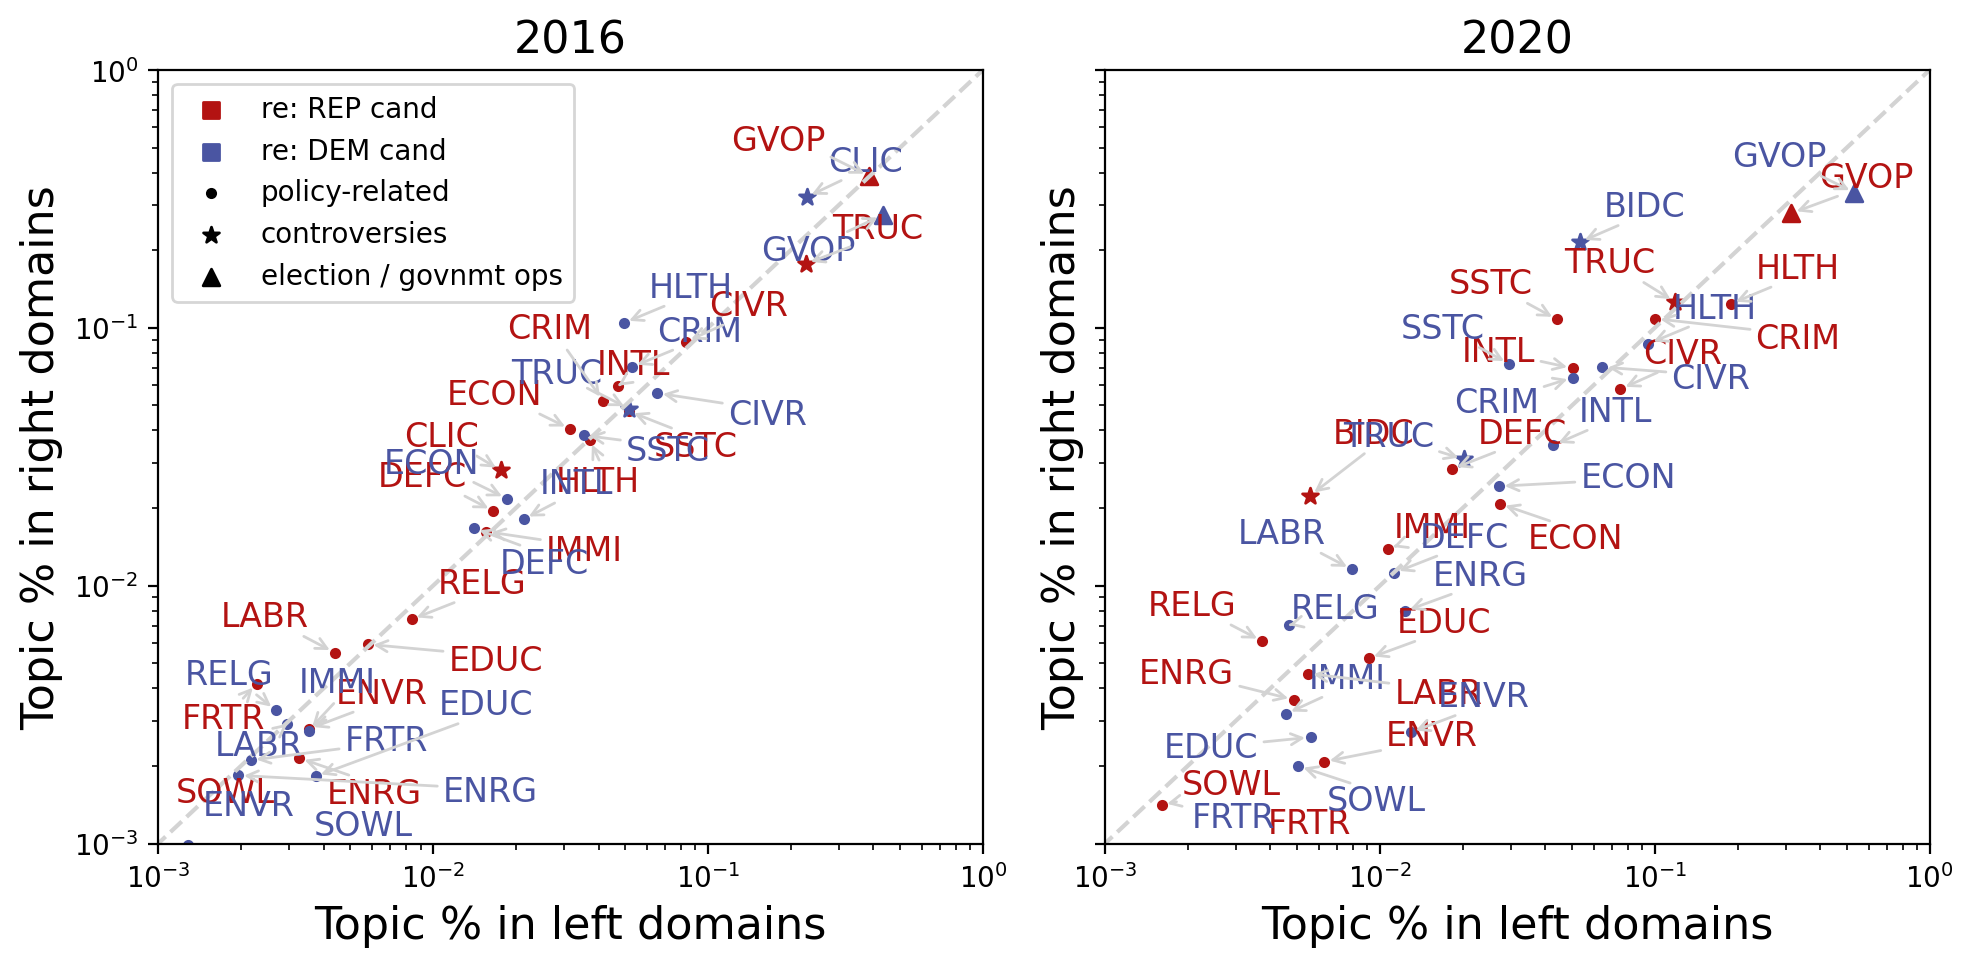

In [60]:
from adjustText import adjust_text
figs, ax = plt.subplots(ncols=2, figsize=(10,5), sharey=True, sharex=True)
# figs, ax = plt.subplots(nrows=2, figsize=(5,10), sharey=True, sharex=True)

# for legend
ax[0].scatter([-10],[-10], color=COLORMAP["right"], marker="s", label="re: REP cand")
ax[0].scatter([-10],[-10], color=COLORMAP["left"], marker="s", label="re: DEM cand")

for marker_group, topic_type in zip([".", "*", "^"], ["policy-related", "controversies", "election / govnmt ops"]):
    plot_df_subset2016 = plot_df2016[plot_df2016["marker"]==marker_group]
    plot_df_subset2020 = plot_df2020[plot_df2020["marker"]==marker_group]

    ax[0].scatter([-10],[-10], color="black", marker=marker_group, label=topic_type)
    # ax[1].scatter([-10],[-10], color="black", marker=marker_group, label=topic_type)

    ax[0].scatter(plot_df_subset2016["left_trump"], plot_df_subset2016["right_trump"], color=COLORMAP["right"], marker=marker_group)
    ax[0].scatter(plot_df_subset2016["left_clinton"], plot_df_subset2016["right_clinton"], color=COLORMAP["left"], marker=marker_group)

    ax[1].scatter(plot_df_subset2020["left_trump"], plot_df_subset2020["right_trump"], color=COLORMAP["right"], marker=marker_group)
    ax[1].scatter(plot_df_subset2020["left_biden"], plot_df_subset2020["right_biden"], color=COLORMAP["left"], marker=marker_group)


for i,year in enumerate([2016, 2020]):
    ax[i].plot([-1,1],[-1,1], color="lightgrey", linestyle="--")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].set_title(year, fontsize=16)
    ax[i].set_xlabel("Topic % in left domains", fontsize=16)
    ax[i].set_ylabel("Topic % in right domains", fontsize=16)
    ax[i].set_xlim(1e-3, 1)
    ax[i].set_ylim(1e-3, 1)
    if i == 0:
        # ax[i].set_ylabel("Topic % in right domains", fontsize=16)
        ax[i].legend(loc=2, fontsize=10)

x1_2016 = plot_df2016["left_trump"].tolist()
y1_2016 = plot_df2016["right_trump"].tolist()
x2_2016 = plot_df2016["left_clinton"].tolist()
y2_2016 = plot_df2016["right_clinton"].tolist()
topics_2016 = [ABBR_MAP[x] for x in plot_df2016["topic"].tolist()]
texts1_2016 = [ax[0].text(x1_2016[n], y1_2016[n], topics_2016[n], color=COLORMAP["right"], fontsize=12) for n in range(len(x1_2016))]
texts2_2016 = [ax[0].text(x2_2016[n], y2_2016[n], topics_2016[n], color=COLORMAP["left"], fontsize=12)  for n in range(len(x2_2016))]
adjust_text(texts1_2016, expand_points=(1.5,2.25), ax=ax[0], arrowprops=dict(arrowstyle="->", color="lightgrey"))
adjust_text(texts2_2016, expand_points=(1.5,2.25), ax=ax[0], arrowprops=dict(arrowstyle="->", color="lightgrey"))

x1_2020 = plot_df2020["left_trump"].tolist()
y1_2020 = plot_df2020["right_trump"].tolist()
x2_2020 = plot_df2020["left_biden"].tolist()
y2_2020 = plot_df2020["right_biden"].tolist()
topics_2020 = [ABBR_MAP[x] for x in plot_df2020["topic"].tolist()]
texts1_2020 = [ax[1].text(x1_2020[n], y1_2020[n], topics_2020[n], color=COLORMAP["right"], fontsize=12) for n in range(len(x1_2020))]
texts2_2020 = [ax[1].text(x2_2020[n], y2_2020[n], topics_2020[n], color=COLORMAP["left"], fontsize=12)  for n in range(len(x2_2020))]
adjust_text(texts1_2020, expand_points=(1.5,2.25), ax=ax[1], arrowprops=dict(arrowstyle="->", color="lightgrey"))
adjust_text(texts2_2020, expand_points=(1.5,2.25), ax=ax[1], arrowprops=dict(arrowstyle="->", color="lightgrey"))

plt.tight_layout()
plt.savefig(OUTPUT_FPATH + "intermedia_scatter_ideo_domains.pdf", dpi=300, bbox_inches="tight")

## Visualize correlation coefficients

In [19]:
corr_func = pearsonr

corr_cred_cand1_2016, _ = get_correlation(plot_df2016["lowc_trump"],plot_df2016["trad_trump"], corr_func=corr_func)
corr_cred_cand2_2016, _ = get_correlation(plot_df2016["lowc_clinton"],plot_df2016["trad_clinton"], corr_func=corr_func)
corr_ideo_cand1_2016, _ = get_correlation(plot_df2016["left_trump"],plot_df2016["right_trump"], corr_func=corr_func)
corr_ideo_cand2_2016, _ = get_correlation(plot_df2016["left_clinton"],plot_df2016["right_clinton"], corr_func=corr_func)

corr_cred_cand1_2020, _ = get_correlation(plot_df2020["lowc_biden"],plot_df2020["trad_biden"], corr_func=corr_func)
corr_cred_cand2_2020, _ = get_correlation(plot_df2020["lowc_trump"],plot_df2020["trad_trump"], corr_func=corr_func)
corr_ideo_cand1_2020, _ = get_correlation(plot_df2020["left_biden"],plot_df2020["right_biden"], corr_func=corr_func)
corr_ideo_cand2_2020, _ = get_correlation(plot_df2020["left_trump"],plot_df2020["right_trump"], corr_func=corr_func)

In [20]:
nruns = 200
corr_arr_cred1_2016 = np.zeros(nruns)
corr_arr_cred2_2016 = np.zeros(nruns)
corr_arr_ideo1_2016 = np.zeros(nruns)
corr_arr_ideo2_2016 = np.zeros(nruns)

corr_arr_cred1_2020 = np.zeros(nruns)
corr_arr_cred2_2020 = np.zeros(nruns)
corr_arr_ideo1_2020 = np.zeros(nruns)
corr_arr_ideo2_2020 = np.zeros(nruns)

for r in range(nruns):    
    corr_arr_cred1_2016[r],_ = get_correlation(plot_df2016[f"bstr{r}_lowc_trump"],plot_df2016["trad_trump"], corr_func=corr_func)
    corr_arr_cred2_2016[r],_ = get_correlation(plot_df2016[f"bstr{r}_lowc_clinton"],plot_df2016["trad_clinton"], corr_func=corr_func)
    corr_arr_ideo1_2016[r],_ = get_correlation(plot_df2016[f"bstr{r}_left_trump"],plot_df2016["right_trump"], corr_func=corr_func)
    corr_arr_ideo2_2016[r],_ = get_correlation(plot_df2016[f"bstr{r}_left_clinton"],plot_df2016["right_clinton"], corr_func=corr_func)

    corr_arr_cred1_2020[r],_ = get_correlation(plot_df2020[f"bstr{r}_lowc_biden"],plot_df2020["trad_biden"], corr_func=corr_func)
    corr_arr_cred2_2020[r],_ = get_correlation(plot_df2020[f"bstr{r}_lowc_trump"],plot_df2020["trad_trump"], corr_func=corr_func)
    corr_arr_ideo1_2020[r],_ = get_correlation(plot_df2020[f"bstr{r}_left_biden"],plot_df2020["right_biden"], corr_func=corr_func)
    corr_arr_ideo2_2020[r],_ = get_correlation(plot_df2020[f"bstr{r}_left_trump"],plot_df2020["right_trump"], corr_func=corr_func)


corr_bot_cred1_2016 = np.percentile(corr_arr_cred1_2016, q=5)
corr_bot_cred2_2016 = np.percentile(corr_arr_cred2_2016, q=5)
corr_bot_ideo1_2016 = np.percentile(corr_arr_ideo1_2016, q=5)
corr_bot_ideo2_2016 = np.percentile(corr_arr_ideo2_2016, q=5)

corr_bot_cred1_2020 = np.percentile(corr_arr_cred1_2020, q=5)
corr_bot_cred2_2020 = np.percentile(corr_arr_cred2_2020, q=5)
corr_bot_ideo1_2020 = np.percentile(corr_arr_ideo1_2020, q=5)
corr_bot_ideo2_2020 = np.percentile(corr_arr_ideo2_2020, q=5)

corr_top_cred1_2016 = np.percentile(corr_arr_cred1_2016, q=95)
corr_top_cred2_2016 = np.percentile(corr_arr_cred2_2016, q=95)
corr_top_ideo1_2016 = np.percentile(corr_arr_ideo1_2016, q=95)
corr_top_ideo2_2016 = np.percentile(corr_arr_ideo2_2016, q=95)

corr_top_cred1_2020 = np.percentile(corr_arr_cred1_2020, q=95)
corr_top_cred2_2020 = np.percentile(corr_arr_cred2_2020, q=95)
corr_top_ideo1_2020 = np.percentile(corr_arr_ideo1_2020, q=95)
corr_top_ideo2_2020 = np.percentile(corr_arr_ideo2_2020, q=95)

corr_avg_cred1_2016 = np.mean(corr_arr_cred1_2016)
corr_avg_cred2_2016 = np.mean(corr_arr_cred2_2016)
corr_avg_ideo1_2016 = np.mean(corr_arr_ideo1_2016)
corr_avg_ideo2_2016 = np.mean(corr_arr_ideo2_2016)

corr_avg_cred1_2020 = np.mean(corr_arr_cred1_2020)
corr_avg_cred2_2020 = np.mean(corr_arr_cred2_2020)
corr_avg_ideo1_2020 = np.mean(corr_arr_ideo1_2020)
corr_avg_ideo2_2020 = np.mean(corr_arr_ideo2_2020)

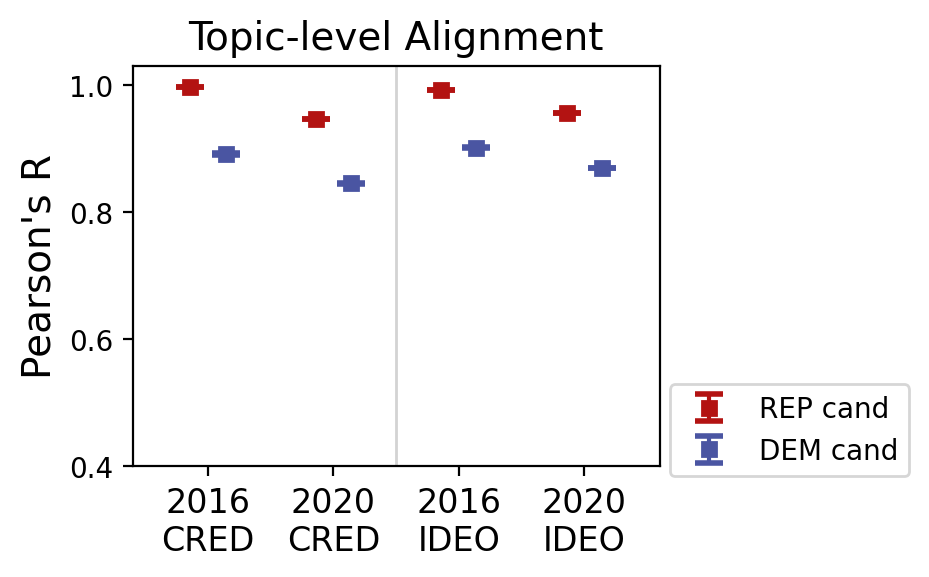

In [21]:
TICKS = ["2016\nCRED", "2020\nCRED", "2016\nIDEO", "2020\nIDEO"]

# y_rep_cand = np.array([corr_cred_cand1_2016, corr_cred_cand2_2020, corr_ideo_cand1_2016, corr_ideo_cand2_2020])
y_rep_cand = np.array([corr_avg_cred1_2016, corr_avg_cred2_2020, corr_avg_ideo1_2016, corr_avg_ideo2_2020])
y_rep_cand_top = np.array([corr_top_cred1_2016, corr_top_cred2_2020, corr_top_ideo1_2016, corr_top_ideo2_2020])
y_rep_cand_bot = np.array([corr_bot_cred1_2016, corr_bot_cred2_2020, corr_bot_ideo1_2016, corr_bot_ideo2_2020])

# y_dem_cand = np.array([corr_cred_cand2_2016, corr_cred_cand1_2020, corr_ideo_cand2_2016, corr_ideo_cand1_2020])
y_dem_cand = np.array([corr_avg_cred2_2016, corr_avg_cred1_2020, corr_avg_ideo2_2016, corr_avg_ideo1_2020])
y_dem_cand_top = np.array([corr_top_cred2_2016, corr_top_cred1_2020, corr_top_ideo2_2016, corr_top_ideo1_2020])
y_dem_cand_bot = np.array([corr_bot_cred2_2016, corr_bot_cred1_2020, corr_bot_ideo2_2016, corr_bot_ideo1_2020])

fig,ax = plt.subplots(figsize=(3.4,2.6))
diff = 0.14
ax.errorbar(
    x=np.arange(4)-diff, y=y_rep_cand, yerr=[y_rep_cand-y_rep_cand_bot, y_rep_cand_top-y_rep_cand], 
    color=COLORMAP["REP"], marker="s", markersize=5, linestyle="", lw=1.5, capsize=5, capthick=2, label="REP cand")
ax.errorbar(
    x=np.arange(4)+diff, y=y_dem_cand, yerr=[y_dem_cand-y_dem_cand_bot, y_dem_cand_top-y_dem_cand], 
    color=COLORMAP["DEM"], marker="s", markersize=5, linestyle="", lw=1.5, capsize=5, capthick=2, label="DEM cand")
ax.set_xticks(range(len(TICKS)), TICKS, fontsize=12)
ax.axvline(x=1.5, color="lightgrey", linewidth=1)
plt.legend(bbox_to_anchor=(1.5, .24))
plt.ylim(.4,1.03)
ax.set_yticks(ax.get_yticks()[::2])
plt.xlim(-.6,3.6)
plt.ylabel("Pearson's R", fontsize=14)
plt.title("Topic-level Alignment", fontsize=14)
plt.savefig(OUTPUT_FPATH + "topic_alignment.pdf", dpi=300, bbox_inches="tight")

In [35]:
(0.5092 +0.7436)/2

0.6264000000000001

In [27]:
y_rep_cand

array([0.99741627, 0.94766933, 0.99143715, 0.95599296])

In [28]:
(0.94475487+0.95364802)/2

0.949201445

In [29]:
y_dem_cand

array([0.89291997, 0.84671228, 0.90202077, 0.87050238])

In [30]:
(0.85316+0.87135917)/2

0.862259585

In [24]:
a = y_rep_cand[1]-y_rep_cand[0]
b = y_rep_cand[3]-y_rep_cand[2]
c = y_dem_cand[1]-y_dem_cand[0]
d = y_dem_cand[3]-y_dem_cand[2]
np.mean([a,b,c,d])

-0.04123366724312996